# Notebook for hypothesis evaluation

* HYP 1 - Na základe osobných vlastností a záujmov je možné predikovať, či sa účastníci matchnú.
* HYP 2 - Na základe vlastností človeka je možné určiť jeho preferenciu na inteligenčnú úroveň jeho partnera (akú inteligenciu majú partneri, ktorých si vybrali).
* HYP 3 - Na základe vlastností človeka a jeho partnera je možné predikovať ako veľmi sa mu páči a ktoré atribúty majú najväčší vplyv.
* HYP 4 - Technickí inžinieri inklinujú k medikom.
* HYP 5 - Športovo založené ženy hľadajú výlučne športovo založených mužov.

In [164]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix


In [112]:
data = pd.read_csv('dataset.csv')
data = data.drop(columns=['Unnamed: 0'])

# Hypoteza 1

### Without hobbies features

In [113]:
data_1 = data.copy()

data_1 = data_1[[
    'match',
    'samerace',
    'int_corr',
    'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me',
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners'
]].dropna()


data_x = data_1.drop(columns=['match'])
data_y = data_1['match']

In [114]:
X_train, X_test, y_train, y_true = train_test_split(data_x, data_y, test_size=0.20, random_state=42 )

### Looking for the best number of classes

Text(0, 0.5, 'auc_score')

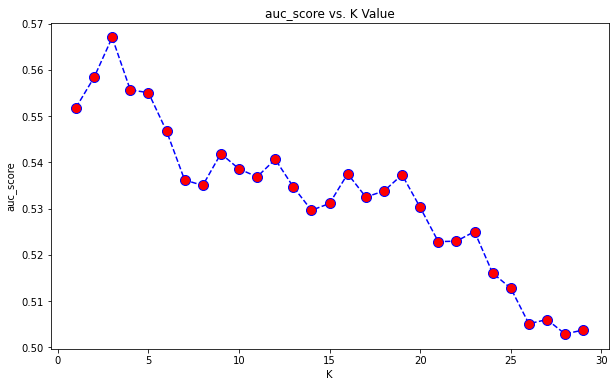

In [116]:
auc_score = []
for i in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict_proba(X_test)
    pred_i = pred_i[:, 1]
    auc_score.append( roc_auc_score(y_test,pred_i) )
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30),auc_score,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('auc_score vs. K Value')
plt.xlabel('K')
plt.ylabel('auc_score')

We see that the best option would have 1 cluster - that doesnt make sense so we will take 3 clusters in further training

In [117]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_i = knn.predict(X_test)

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')

# print(classification_report(y_test,pred_i))

Area under ROC curve is 0.5345238784370479


## Printing ROC curve

Logistic: ROC AUC=0.567


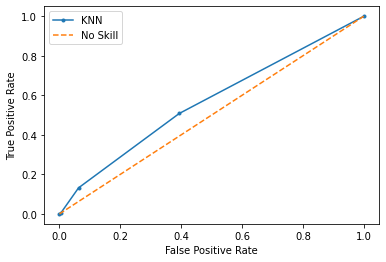

In [118]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# predict probabilities
_probs = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
_probs = _probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
auc = roc_auc_score(y_test, _probs)
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (auc))
# calculate roc curves
_fpr, _tpr, _ = roc_curve(y_test, _probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the roc curve for the model
plt.plot(_fpr, _tpr, marker='.', label='KNN')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Printing confusion matrix

In [119]:
confusion_matrix(y_test, y_pred)

array([[1295,   87],
       [ 217,   33]], dtype=int64)

In [120]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.86      0.94      0.89      1382\n           1       0.28      0.13      0.18       250\n\n    accuracy                           0.81      1632\n   macro avg       0.57      0.53      0.54      1632\nweighted avg       0.77      0.81      0.79      1632\n'

## With hobbies

In [97]:
data_1 = data.copy()

data_1 = data_1[[
    'match',
    'samerace',
    'int_corr',
    'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me',
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners',
    
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners',
    
]].dropna()


data_x = data_1.drop(columns=['match'])
data_y = data_1['match']

X_train, X_test, y_train, y_true = train_test_split(data_x, data_y, test_size=0.20, random_state=42 )

Text(0, 0.5, 'auc_score')

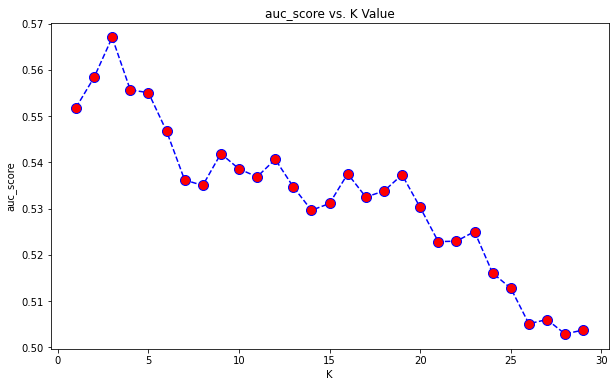

In [121]:
auc_score = []
for i in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict_proba(X_test)
    pred_i = pred_i[:, 1]
    auc_score.append( roc_auc_score(y_test,pred_i) )
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30),auc_score,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('auc_score vs. K Value')
plt.xlabel('K')
plt.ylabel('auc_score')

In [124]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_i = knn.predict_proba(X_test)
pred_i = pred_i[:, 1]

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')


Area under ROC curve is 0.567013024602026


Logistic: ROC AUC=0.567


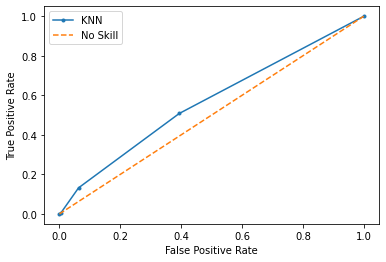

In [125]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# predict probabilities
_probs = knn.predict_proba(X_test)
# keep probabilities for the positive outcome only
_probs = _probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
auc = roc_auc_score(y_test, _probs)
ns_auc = roc_auc_score(y_test, ns_probs)
# summarize scores
print('Logistic: ROC AUC=%.3f' % (auc))
# calculate roc curves
_fpr, _tpr, _ = roc_curve(y_test, _probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plot the roc curve for the model
plt.plot(_fpr, _tpr, marker='.', label='KNN')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### HYPOTHESIS 2
Na základe vlastností človeka je možné určiť jeho preferenciu na inteligenčnú úroveň jeho partnera (akú inteligenciu majú partneri, ktorých si vybrali).

In [149]:
data_2 = data.copy()

In [150]:
df_personal = data_2[[
  'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me', 'iid', 'pid', 'match', 'intel_me_partners', 'dec', 'dec_partner',
    'career','career_c'
]]

In [151]:
df_personal = df_personal[df_personal['match']==1]

df_personal.dropna(inplace=True)

df_personal_y = df_personal['intel_me_partners']
df_personal_x = df_personal.drop(columns=['intel_me_partners'])



### Is there realtionship between our features and predicting value ?


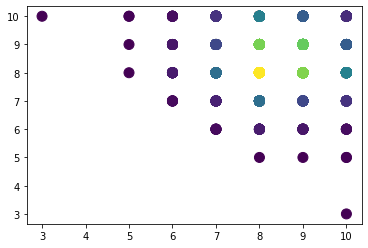

In [6]:
### toto len spustit v cykle na vsetky slptce a pridat k tomu popiskuy a mozn oto dat do riadky....
x = df_personal['intel_me']
y = df_personal['intel_me_partners']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

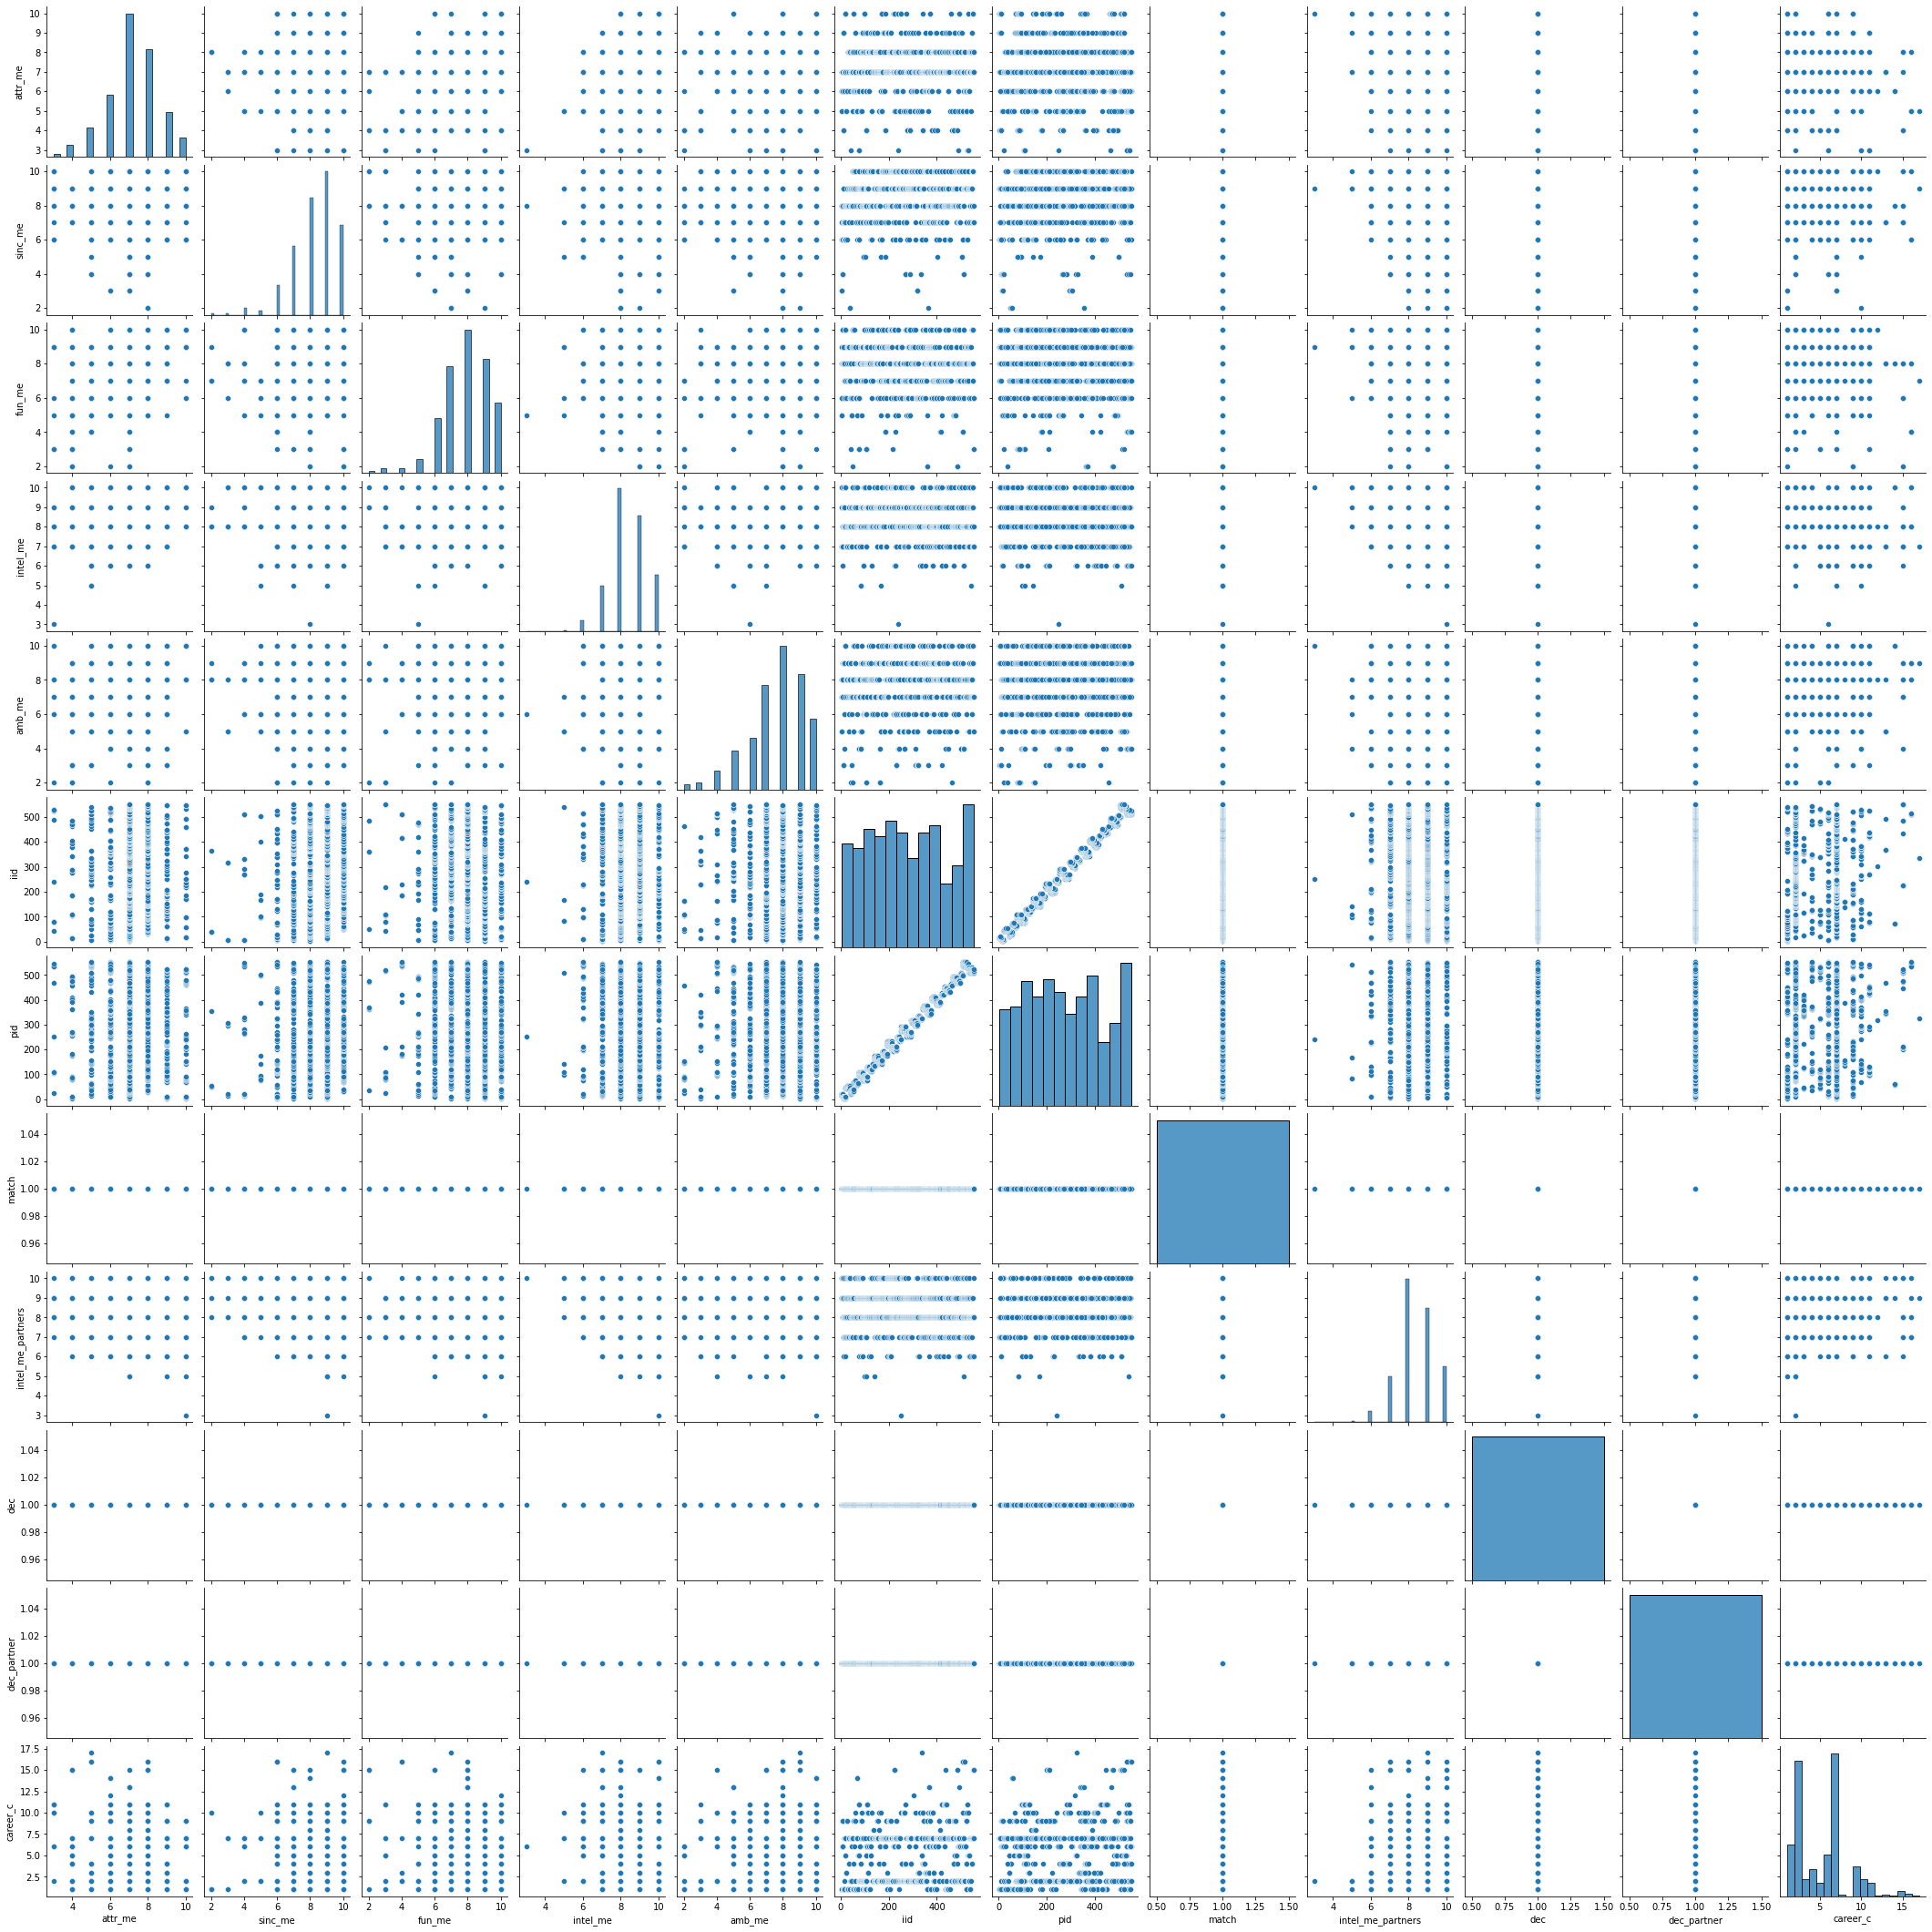

In [7]:
sns.pairplot(df_personal)

V tomto gulasi je pre nas podstatny stlpec intel_me_partners a zo 5 atributov. VIdime ziadna korelaciu napr v riadku s intel_me, kde sa centralizuju bodecky v pravom hornom rohu - a to chceme, to znamena ze intelinny ludia skor chcu inteligentych partnerov - takze tam moze byt zavislost na modelovanie... Idelane tento  fraf spravit tak ze bodky budu zohladnovat pocet interakcii a mozno zeby tu boli len tie grafy ktore maju byt....

# Poisson regression

In [8]:
df_personal.describe()

,attr_me,sinc_me,fun_me,intel_me,amb_me,iid,pid,match,intel_me_partners,dec,dec_partner,career_c
count,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.0,1315.000000,1315.0,1315.0,1315.000000
mean,7.200760,8.295817,7.879848,8.418251,7.622814,276.711027,276.634981,1.0,8.411407,1.0,1.0,5.118631
std,1.361852,1.393048,1.478670,1.015092,1.719021,158.973764,159.094476,0.0,1.015267,0.0,0.0,3.236198
min,3.000000,2.000000,2.000000,3.000000,2.000000,4.000000,1.000000,1.0,3.000000,1.0,1.0,1.000000
25%,6.000000,8.000000,7.000000,8.000000,7.000000,141.500000,141.500000,1.0,8.000000,1.0,1.0,2.000000
50%,7.000000,9.000000,8.000000,8.000000,8.000000,269.000000,269.000000,1.0,8.000000,1.0,1.0,6.000000
75%,8.000000,9.000000,9.000000,9.000000,9.000000,404.000000,404.000000,1.0,9.000000,1.0,1.0,7.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,552.000000,552.000000,1.0,10.000000,1.0,1.0,17.000000


### Fitting of the model

In [152]:
X_train, X_test, y_train, y_test = train_test_split(df_personal_x, df_personal_y, test_size=0.20, random_state=42 )

In [153]:
clf = linear_model.PoissonRegressor()
clf.fit(X_train[['attr_me','intel_me','sinc_me','amb_me']], y_train)
clf.score(X_train[['attr_me','intel_me','sinc_me','amb_me']], y_train)
y_pred = clf.predict(X_test[['attr_me','intel_me','sinc_me','amb_me']])
print(mean_squared_error(y_test, y_pred))

gamma_model = sm.GLM(y_train,X_train[['attr_me','intel_me','sinc_me','amb_me']], family=sm.families.Poisson())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

1.0329028926559116
                 Generalized Linear Model Regression Results                  
Dep. Variable:      intel_me_partners   No. Observations:                 1052
Model:                            GLM   Df Residuals:                     1048
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2395.1
Date:                Sat, 19 Mar 2022   Deviance:                       603.35
Time:                        17:38:14   Pearson chi2:                     644.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
attr_me        0.0304      0.009 

popis k vystupu

## Are there any error, outliers, specific points... - NO

In [11]:
df_pred = X_train[['attr_me','intel_me','sinc_me','amb_me']]

In [12]:
df_pred.describe()

,attr_me,intel_me,sinc_me,amb_me
count,1052.000000,1052.000000,1052.000000,1052.000000
mean,7.199620,8.405894,8.270913,7.623574
std,1.360752,1.012615,1.414143,1.684127
min,3.000000,3.000000,2.000000,2.000000
25%,6.000000,8.000000,8.000000,7.000000
50%,7.000000,8.000000,8.000000,8.000000
75%,8.000000,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000


<AxesSubplot:>

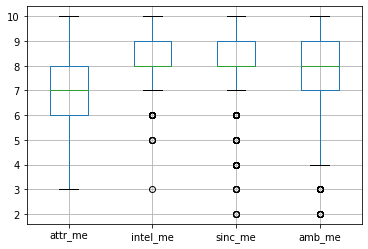

In [13]:
df_pred.boxplot()

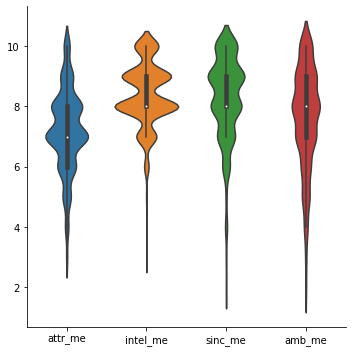

In [14]:
sns.catplot( kind="violin", data=df_pred)

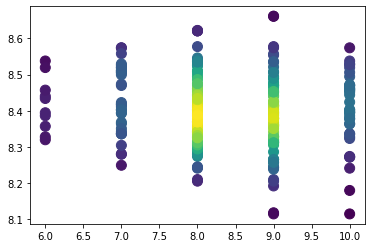

In [15]:
### toto len spustit v cykle na vsetky slptce a pridat k tomu popiskuy a mozn oto dat do riadky....
x = y_test
y = y_pred

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

## Hypothesis testing 

chi square ma byt 0 a je 640


Treba viacej zinterpretovat ??? nieco najst ako na a spytat sa ho

### Oplati saa byt intelinglym aby sme si nasli inteligentnejsieho partnera

# Hypothesis 3

In [154]:
data_3 = data.copy()

data_3 = data_3[[
    'match',
    'samerace',
    'int_corr',
    'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me',
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners',
    'iid_like_pid'
   
]].dropna()

data_3['attr_me_my_partner_diff'] = data_3['attr_me'] - data_3['attr_me_partners']
data_3['sinc_me_my_partner_diff'] = data_3['sinc_me'] - data_3['sinc_me_partners']
data_3['fun_me_my_partner_diff'] = data_3['fun_me'] - data_3['fun_me_partners']
data_3['intel_me_my_partner_diff'] = data_3['intel_me'] - data_3['intel_me_partners']
data_3['amb_me_my_partner_diff'] = data_3['amb_me'] - data_3['amb_me_partners']

attrs = [
    'attr_me_my_partner_diff', 'sinc_me_my_partner_diff', 'fun_me_my_partner_diff',
    'intel_me_my_partner_diff', 'amb_me_my_partner_diff'
        ]

attr_me_my_partner_diff


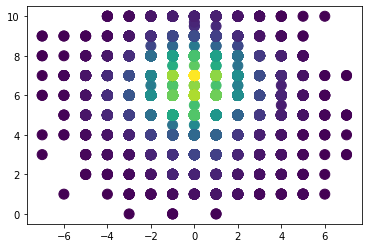

sinc_me_my_partner_diff


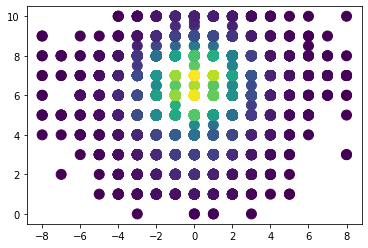

fun_me_my_partner_diff


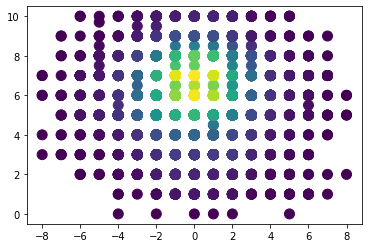

intel_me_my_partner_diff


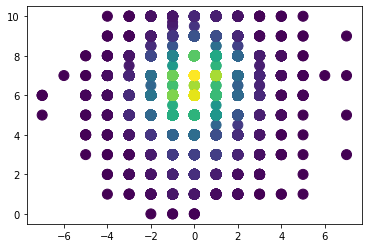

amb_me_my_partner_diff


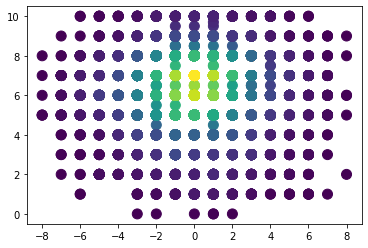

In [155]:
for i in attrs:
    print(i)
    x = data_3[i]
    y = data_3['iid_like_pid']

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100)
    plt.show()

In [157]:
data_x = data_3.drop(columns="iid_like_pid")
data_y = data_3['iid_like_pid']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42 )

In [159]:


gamma_model = sm.GLM(y_train,X_train, family=sm.families.Poisson())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           iid_like_pid   No. Observations:                 6348
Model:                            GLM   Df Residuals:                     6335
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13534.
Date:                Sat, 19 Mar 2022   Deviance:                       4096.5
Time:                        17:38:51   Pearson chi2:                 3.83e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
match                   

In [166]:
y_pred = gamma_results.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mse/len(y_pred))

In [167]:
print(rmse)

0.045187223777462246


In [168]:
y_pred.describe()

count    1587.000000
mean        6.043556
std         0.978759
min         3.242746
25%         5.357108
50%         5.962667
75%         6.603652
max        10.140530
dtype: float64

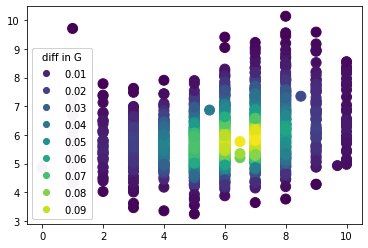

In [172]:
### toto len spustit v cykle na vsetky slptce a pridat k tomu popiskuy a mozn oto dat do riadky....
x = y_test
y = y_pred

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="diff in G")
ax.add_artist(legend1)

plt.show()

# Medicky a inzinieri

### Model formalism

In [175]:
data_4 = data.copy()

In [176]:
df_personal = data_4[[
  'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me', 'iid', 'pid', 'match', 'intel_me_partners', 'dec', 'dec_partner',
    'career','career_c', 'career_c_partners', 'gender', 'gender_partners'
]]

df_personal_career = df_personal[ (df_personal['career_c'] == 4) | (df_personal['career_c'] == 5)   ]

#### Medicky s enziniermi

In [177]:
df_match = df_personal_career[ df_personal_career['match']==1 ]

df_match = df_match[['career_c','career_c_partners']]


In [189]:
def calc_logit(df_match, prof_1, prof_2 ):

    df_match['career_y'] = df_match['career_c']==prof_1

    df_match['career_c_partners_y'] = df_match['career_c_partners']==prof_2
    
    df_match.replace({True:1,False:0},inplace=True)
    
    if df_match[df_match['career_c_partners_y'] == 1].empty == True:
        return
                
    logit_mod = sm.Logit( df_match['career_y'] , df_match['career_c_partners_y'] )

    logit_res = logit_mod.fit()
    
    x = df_match['career_y']
    y = df_match['career_c_partners_y']

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    
    ax.scatter(x, y, c=z, s=100)
    ax.legend()
    plt.show()

    print(logit_res.summary())

No handles with labels found to put in legend.


1
Optimization terminated successfully.
         Current function value: 0.674964
         Iterations 5


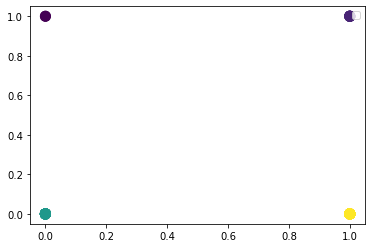

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.05334
Time:                        18:04:20   Log-Likelihood:                -71.546
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y     1.3863      0.791      1.754      0.080      -0.163       2.936
2
Optimization terminated successfully.
         Current function value: 0.677516
         Iterations 4


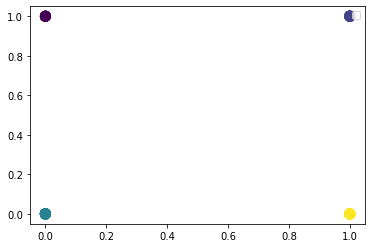

                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.05732
Time:                        18:04:20   Log-Likelihood:                -71.817
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y     0.7538      0.429      1.758      0.079      -0.087       1.594
3
Optimization terminated successfully.

No handles with labels found to put in legend.



         Current function value: 0.693147
         Iterations 1


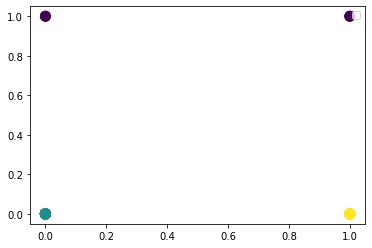

                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.08172
Time:                        18:04:20   Log-Likelihood:                -73.474
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y          0      1.000          0      1.000      -1.960       1.960
4


C:\Users\Timo\.conda\envs\kralik\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
No handles with labels found to put in legend.


         Current function value: 0.673624
         Iterations: 35


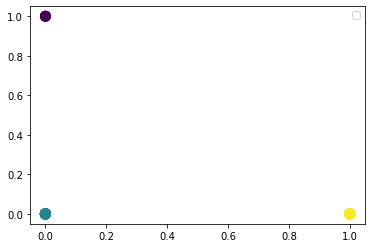

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.05125
Time:                        18:04:21   Log-Likelihood:                -71.404
converged:                      False   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y    -5.7057     10.043     -0.568      0.570     -25.389      13.978
5
Optimization terminated successfully.
         Current function value: 0.688339
         Iterations 4


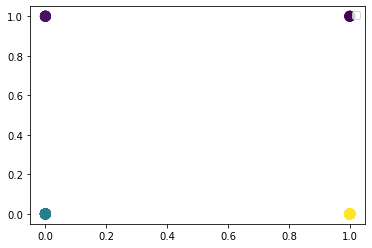

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.07421
Time:                        18:04:21   Log-Likelihood:                -72.964
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y    -0.6931      0.707     -0.980      0.327      -2.079       0.693
6
Optimization terminated successfully.
         Current function value: 0.683275
         Iterations 5


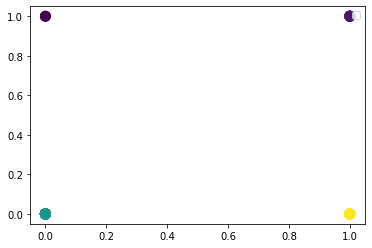

                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.06631
Time:                        18:04:21   Log-Likelihood:                -72.427
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y     1.0986      0.816      1.346      0.178      -0.502       2.699
7


No handles with labels found to put in legend.


Optimization terminated successfully.
         Current function value: 0.633997
         Iterations 5


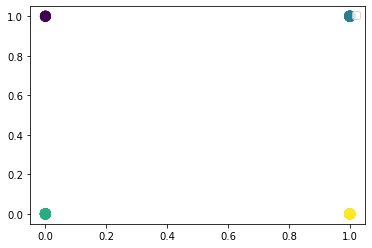

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                 0.01059
Time:                        18:04:21   Log-Likelihood:                -67.204
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y     1.5261      0.493      3.093      0.002       0.559       2.493
8
9
Optimization terminated successfully.
         Current function value: 0.691544
         Iterations 

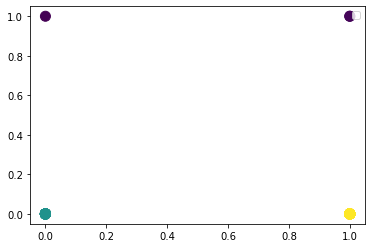

                           Logit Regression Results                           
Dep. Variable:               career_y   No. Observations:                  106
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.07921
Time:                        18:04:21   Log-Likelihood:                -73.304
converged:                       True   LL-Null:                       -67.923
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
career_c_partners_y     0.6931      1.225      0.566      0.571      -1.707       3.094


In [190]:
for i in range(1,10):
    print(i)
    calc_logit(df_match.copy(), 4,i)

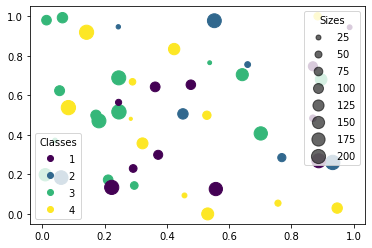

In [24]:
N = 45
x, y = np.random.rand(2, N)
c = np.random.randint(1, 5, size=N)
s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, s=s)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

# Hypothesis 5

In [240]:
data_4 = data.copy()

In [241]:
df_personal = data_4[[
  'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me', 'iid', 'pid', 'match', 'intel_me_partners', 'dec', 'dec_partner',
    'career','career_c', 'career_c_partners', 'gender', 'gender_partners',
    
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners',
    
    
]]

colls = [
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners'
]
df_personal = df_personal[df_personal['match']==1]


In [242]:
def calc_logit(df_match, prof_1, prof_2 ):           
    logit_mod = sm.Logit( df_match[prof_1] , df_match[prof_2] )

    logit_res = logit_mod.fit()
    
    x = df_match[prof_1]
    y = df_match[prof_2]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    
    ax.scatter(x, y, c=z, s=100)
    ax.legend()
    plt.show()

    print(logit_res.summary())

No handles with labels found to put in legend.


sports
Optimization terminated successfully.
         Current function value: 0.688606
         Iterations 4


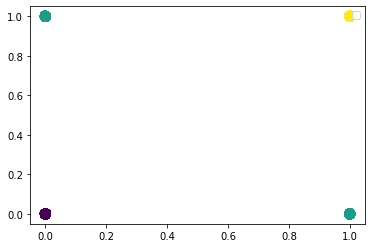

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                 sports   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.01208
Time:                        18:25:10   Log-Likelihood:                -950.28
converged:                       True   LL-Null:                       -938.93
Covariance Type:            nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sports_partners     0.2513      0.071      3.526      0.000       0.112       0.391
tvsports
Optimization terminated successfully.
         Current function value: 0.691974
         Iterations 3


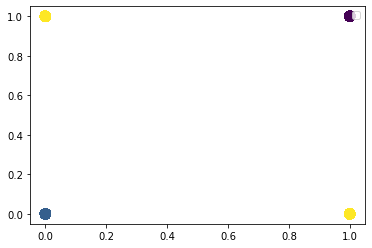

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               tvsports   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                0.001618
Time:                        18:25:10   Log-Likelihood:                -954.92
converged:                       True   LL-Null:                       -956.47
Covariance Type:            nonrobust   LLR p-value:                       nan
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
tvsports_partners    -0.1378      0.077     -1.797      0.072      -0.288       0.013
exercise
Optimization terminated successfully.
         Current function value: 0.690610
         Iterations 4

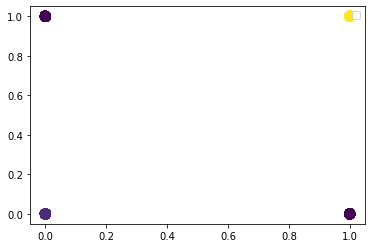

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               exercise   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                0.002207
Time:                        18:25:11   Log-Likelihood:                -953.04
converged:                       True   LL-Null:                       -955.15
Covariance Type:            nonrobust   LLR p-value:                       nan
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
exercise_partners     0.1976      0.075      2.640      0.008       0.051       0.344
dining
Optimization terminated successfully.
         Current function value: 0.669578
         Iterations 4


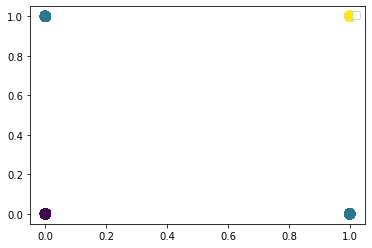

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                 dining   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.02860
Time:                        18:25:11   Log-Likelihood:                -924.02
converged:                       True   LL-Null:                       -898.33
Covariance Type:            nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
dining_partners     0.5512      0.070      7.915      0.000       0.415       0.688
museums
Optimization terminated successfully.
         Current function value: 0.688907
         Iterations 4


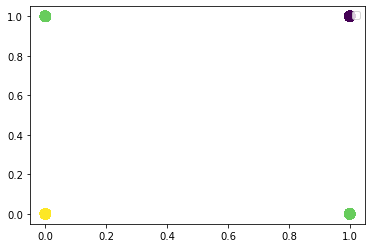

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                museums   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                0.001366
Time:                        18:25:11   Log-Likelihood:                -950.69
converged:                       True   LL-Null:                       -951.99
Covariance Type:            nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
museums_partners    -0.2730      0.080     -3.405      0.001      -0.430      -0.116
art
Optimization terminated successfully.
         Current function value: 0.675024
         Iterations 4


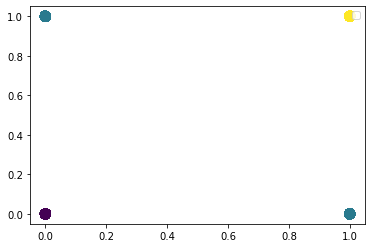

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                    art   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.02179
Time:                        18:25:11   Log-Likelihood:                -931.53
converged:                       True   LL-Null:                       -911.67
Covariance Type:            nonrobust   LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
art_partners     0.4881      0.070      6.969      0.000       0.351       0.625
hiking
Optimization terminated successfully.
         Current function value: 0.687337
         Iterations 4


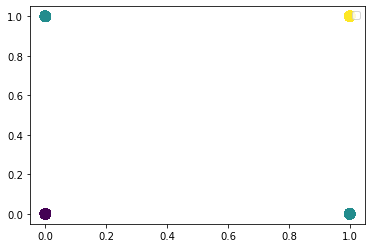

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                 hiking   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:               -0.009874
Time:                        18:25:12   Log-Likelihood:                -948.53
converged:                       True   LL-Null:                       -939.25
Covariance Type:            nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
hiking_partners     0.2848      0.071      3.984      0.000       0.145       0.425
gaming
Optimization terminated successfully.
         Current function value: 0.690198
         Iterations 4


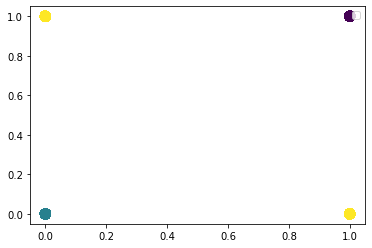

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                 gaming   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                0.003869
Time:                        18:25:12   Log-Likelihood:                -952.47
converged:                       True   LL-Null:                       -956.17
Covariance Type:            nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
gaming_partners    -0.2205      0.078     -2.845      0.004      -0.372      -0.069
clubbing
Optimization terminated successfully.
         Current function value: 0.692185
         Iterations 3


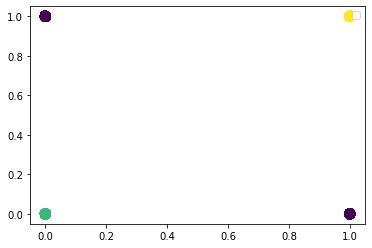

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               clubbing   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                0.001313
Time:                        18:25:12   Log-Likelihood:                -955.22
converged:                       True   LL-Null:                       -956.47
Covariance Type:            nonrobust   LLR p-value:                       nan
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
clubbing_partners     0.1235      0.076      1.628      0.104      -0.025       0.272
reading
Optimization terminated successfully.
         Current function value: 0.672478
         Iterations 4


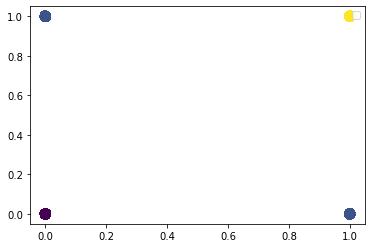

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                reading   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:               -0.002350
Time:                        18:25:13   Log-Likelihood:                -928.02
converged:                       True   LL-Null:                       -925.84
Covariance Type:            nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
reading_partners     0.5320      0.072      7.422      0.000       0.391       0.672
tv
Optimization terminated successfully.
         Current function value: 0.692595
         Iterations 3


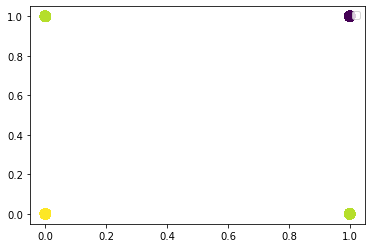

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                     tv   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:               0.0003060
Time:                        18:25:13   Log-Likelihood:                -955.78
converged:                       True   LL-Null:                       -956.07
Covariance Type:            nonrobust   LLR p-value:                       nan
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
tv_partners    -0.0953      0.077     -1.234      0.217      -0.247       0.056
theater
Optimization terminated successfully.
         Current function value: 0.686915
         Iterations 4


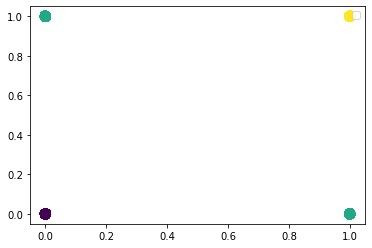

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                theater   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.02628
Time:                        18:25:13   Log-Likelihood:                -947.94
converged:                       True   LL-Null:                       -923.67
Covariance Type:            nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
theater_partners     0.2877      0.070      4.126      0.000       0.151       0.424
movies
Optimization terminated successfully.
         Current function value: 0.678414
         Iterations 4


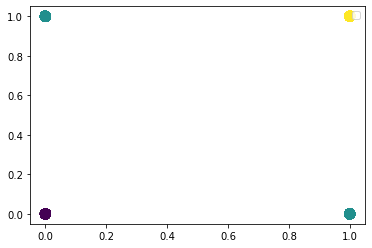

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                 movies   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.03360
Time:                        18:25:13   Log-Likelihood:                -936.21
converged:                       True   LL-Null:                       -905.78
Covariance Type:            nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
movies_partners     0.4360      0.069      6.302      0.000       0.300       0.572
concerts
Optimization terminated successfully.
         Current function value: 0.679701
         Iterations 4


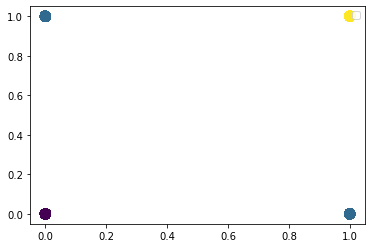

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               concerts   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:               -0.007359
Time:                        18:25:14   Log-Likelihood:                -937.99
converged:                       True   LL-Null:                       -931.13
Covariance Type:            nonrobust   LLR p-value:                       nan
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
concerts_partners     0.4299      0.071      6.022      0.000       0.290       0.570
music
Optimization terminated successfully.
         Current function value: 0.678818
         Iterations 4


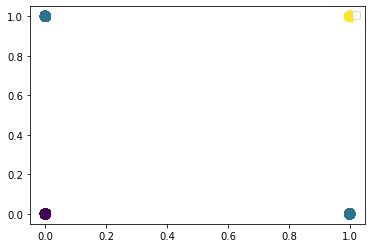

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:                  music   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:                -0.01180
Time:                        18:25:14   Log-Likelihood:                -936.77
converged:                       True   LL-Null:                       -925.84
Covariance Type:            nonrobust   LLR p-value:                       nan
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
music_partners     0.4405      0.071      6.213      0.000       0.302       0.579
shopping
Optimization terminated successfully.
         Current function value: 0.692336
         Iterations 3


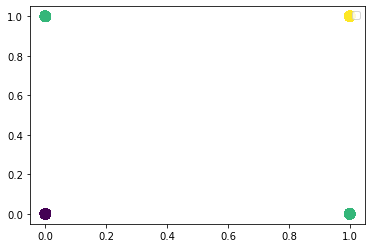

No handles with labels found to put in legend.


                           Logit Regression Results                           
Dep. Variable:               shopping   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:               -0.004500
Time:                        18:25:14   Log-Likelihood:                -955.42
converged:                       True   LL-Null:                       -951.14
Covariance Type:            nonrobust   LLR p-value:                       nan
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
shopping_partners     0.1093      0.073      1.495      0.135      -0.034       0.253
yoga
Optimization terminated successfully.
         Current function value: 0.693094
         Iterations 3


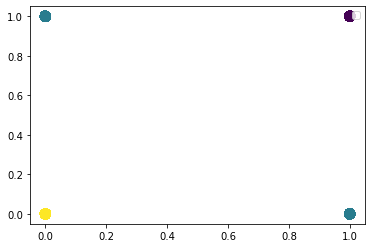

                           Logit Regression Results                           
Dep. Variable:                   yoga   No. Observations:                 1380
Model:                          Logit   Df Residuals:                     1379
Method:                           MLE   Df Model:                            0
Date:                Sat, 19 Mar 2022   Pseudo R-squ.:              -0.0001411
Time:                        18:25:14   Log-Likelihood:                -956.47
converged:                       True   LL-Null:                       -956.33
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
yoga_partners    -0.0295      0.077     -0.384      0.701      -0.180       0.121


In [243]:
atrs = [
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga'
]

for i in atrs:
    
    mean_i = df_personal[i].mean()
    df_personal[i] = df_personal[i] > mean_i
    df_personal[i+'_partners'] = df_personal[i+'_partners'] > mean_i

df_personal = df_personal.replace({True:1,False:0})

for i in atrs:
    print(i)
    calc_logit(df_personal.copy(), i,i+'_partners')